In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import a Gaussian process regressor and define your custom kernel.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Import PySR for symbolic regression.
from pysr import PySRRegressor
import os
os.environ["JULIA_NUM_THREADS"] = "8"  # Use 8 threads (adjust as needed)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# =========================
# 1. Load and Prepare Data
# =========================
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/real_estate_valuation_cleaned.csv")
# Use "X2 distance MRT station" and "X3 number convenience stores" as predictors,
# and "X6 price" as the target.
X = data[["X2 distance MRT station", "X3 number convenience stores"]].values
y = data["X6 price"].values

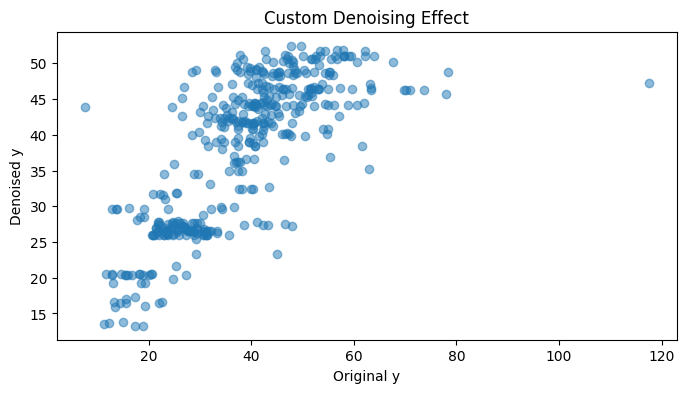

In [17]:
# ========================================
# 2. Custom Denoising via Gaussian Process
# ========================================
# Define a custom kernel. For less smoothing, use a smaller RBF length scale.
custom_kernel = ConstantKernel(1.0) * RBF(length_scale=0.01) + WhiteKernel(noise_level=10.0)
gp = GaussianProcessRegressor(kernel=custom_kernel, n_restarts_optimizer=10)
gp.fit(X, y)
# Generate denoised targets using your custom GP.
y_denoised_custom = gp.predict(X)

# Optionally, you can visualize the effect of denoising:
plt.figure(figsize=(8,4))
plt.scatter(y, y_denoised_custom, alpha=0.5)
plt.xlabel("Original y")
plt.ylabel("Denoised y")
plt.title("Custom Denoising Effect")
plt.show()

26.3**2 * RBF(length_scale=30) + WhiteKernel(noise_level=62.8)


c:\Users\svenl\miniconda3\envs\hyperRealDataDescriber\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 30.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


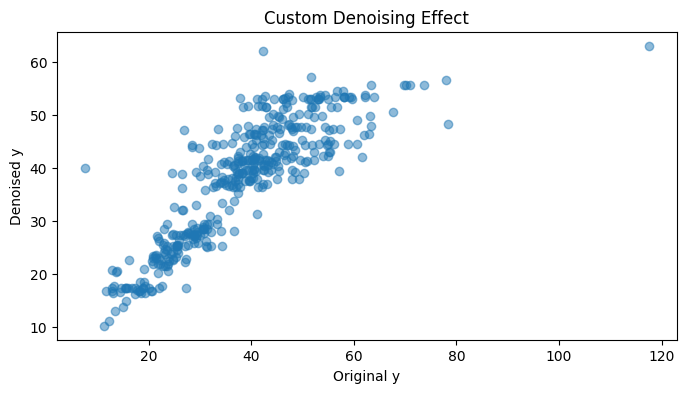

In [37]:
# Fix the hyperparameters by setting bounds to "fixed"
kernel = (ConstantKernel(1.0, constant_value_bounds="fixed") *
          RBF(length_scale=0.1, length_scale_bounds="fixed") +
          WhiteKernel(noise_level=1.0, noise_level_bounds="fixed"))

# # Disable optimization by setting optimizer=None
# gp_fixed = GaussianProcessRegressor(kernel=kernel, optimizer=None)
# gp_fixed.fit(X, y)
kernel = (ConstantKernel(1.0, (1e-3, 1e3)) *
          RBF(length_scale=0.1, length_scale_bounds=(1e-3, 30)) +
          WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e3)))

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=5)
gp.fit(X, y)
print(gp.kernel_)
y_denoised_fixed = gp.predict(X)

# Optionally, you can visualize the effect of denoising:
plt.figure(figsize=(8,4))
plt.scatter(y, y_denoised_fixed, alpha=0.5)
plt.xlabel("Original y")
plt.ylabel("Denoised y")
plt.title("Custom Denoising Effect")
plt.show()

In [38]:
# ====================================================
# 3. Run PySR on the Custom-Denoised Targets (No Built-in Denoising)
# ====================================================
# Here, we disable PySR's built-in denoising (denoise=False)
# because we've already processed the targets.
model = PySRRegressor(niterations=1000, denoise=False, progress=True)
model.fit(X, y_denoised_fixed)
print("Discovered symbolic regression model:")
print(model)

c:\Users\svenl\miniconda3\envs\hyperRealDataDescriber\Lib\site-packages\pysr\sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.960e+04
Progress: 432 / 31000 total iterations (1.394%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.312e+02  1.594e+01  y = 37.682
3           9.377e+01  1.679e-01  y = x₁ + 33.584
5           4.424e+01  3.756e-01  y = (x₀ * -0.0073978) + 45.698
7           3.673e+01  9.302e-02  y = (x₁ + 40.079) - (x₀ * 0.0059909)
9           3.655e+01  2.468e-03  y = 39.061 - ((x₁ / -0.84643) + (x₀ * 0.005736))
11          3.347e+01  4.407e-02  y = ((x₁ - (x₀ * 0.0053083)) - (-472.64 / x₀)) + 37.902
15          3.346e+01  4.408e-05  y = ((20.03 / (x₀ / 23.843)) + 38.072) - ((x₁ * -0.96585) ...
                                      - (x₀ * -0.0053491))
17          3.334e+01  1.775e-03  y = ((x₁ + 32.889) * (x₀ * (-150.07 - (x₀ * -0.021049)))) ...
        

[ Info: Final population:
[ Info: Results saved to:


Discovered symbolic regression model:
PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          37.681713   
	1         0.167931                                      x1 + 33.58402   
	2   >>>>  0.648646                       96205.266 / (x0 + 1814.2719)   
	3         0.029441            (48336.33 / (x0 + 1047.7969)) + 9.49781   
	4         0.001786   (48548.895 / ((x0 - x1) + 1058.7047)) + 9.478296   
	5         0.020385  96205.266 / (((-2053.9905 / (297.9399 - x0)) +...   
	6         0.004696  96348.68 / (x0 + (((x0 * -5.1377697) / (296.50...   
	7         0.028047  (-2908.3652 / ((x0 + ((-1665.4081 / (297.56116...   
	8         0.015377  (-2908.3696 / ((((x0 + (-1665.3967 / (298.0135...   
	9         0.013287  ((x1 * 0.49227062) - -9.57434) + (-2908.3555 /...   
	10        0.000013  ((x1 * 0.49228093) - -9.574344) + (-2908.3555 ...   
	11        0.003325  (-3172.2585 / (((x0 + (-

In [39]:
# ==========================================
# 4. Candidate Selection and Conversion (Example)
# ==========================================
# Let's say you select the first candidate function.
selected_eq_str = model.equations_.iloc[8]['equation']
print("Selected candidate equation:", selected_eq_str)

# Convert the candidate string to a sympy expression.
from sympy import sympify, symbols, lambdify
f_sympy = sympify(selected_eq_str)
# Identify free symbols in the expression (e.g. "x0", "x1")
free_syms = sorted(f_sympy.free_symbols, key=lambda s: s.name)
print("Free symbols:", free_syms)
# Create a lambda function for numerical evaluation.
f_callable = lambdify(free_syms, f_sympy, 'numpy')

def candidate_function(X):
    # Assumes ordering: first free symbol -> first column, etc.
    if len(free_syms) == 1:
        return f_callable(X[:, 0])
    elif len(free_syms) == 2:
        return f_callable(X[:, 0], X[:, 1])
    else:
        args = [X[:, i] for i in range(len(free_syms))]
        return f_callable(*args)

Selected candidate equation: (-2908.3696 / ((((x0 + (-1665.3967 / (298.01358 - x0))) + 1153.7653) / -15.973039) + x1)) + 10.618768
Free symbols: [x0, x1]


In [41]:
# ==========================================
# 5. Reintroduce Noise to Match Original Distribution
# ==========================================
# Estimate the noise level using residuals between original and denoised targets.
residuals = y - y_denoised_custom
noise_std = np.std(residuals)
print("Estimated noise standard deviation:", noise_std)

# You can optionally amplify the noise if needed:
noise_factor = 1.0  # adjust this factor as desired
noise_std_amplified = noise_std * noise_factor

def predict_with_noise(func, X, noise_std):
    y_pred = func(X)
    noise = np.random.normal(0, noise_std, size=y_pred.shape)
    return y_pred + noise

# Generate predictions using the candidate function and add noise.
y_pred_with_noise = predict_with_noise(candidate_function, X, noise_std_amplified)

Estimated noise standard deviation: 8.874110712717487


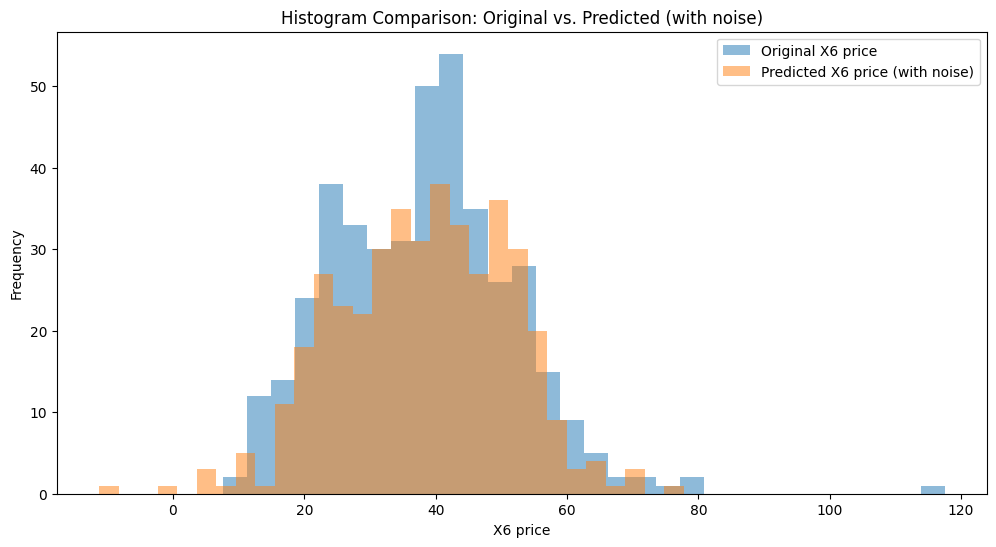

In [13]:
# ==========================================
# 6. Visualization
# ==========================================
plt.figure(figsize=(12, 6))
plt.hist(y, bins=30, alpha=0.5, label="Original X6 price")
plt.hist(y_pred_with_noise, bins=30, alpha=0.5, label="Predicted X6 price (with noise)")
plt.xlabel("X6 price")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()

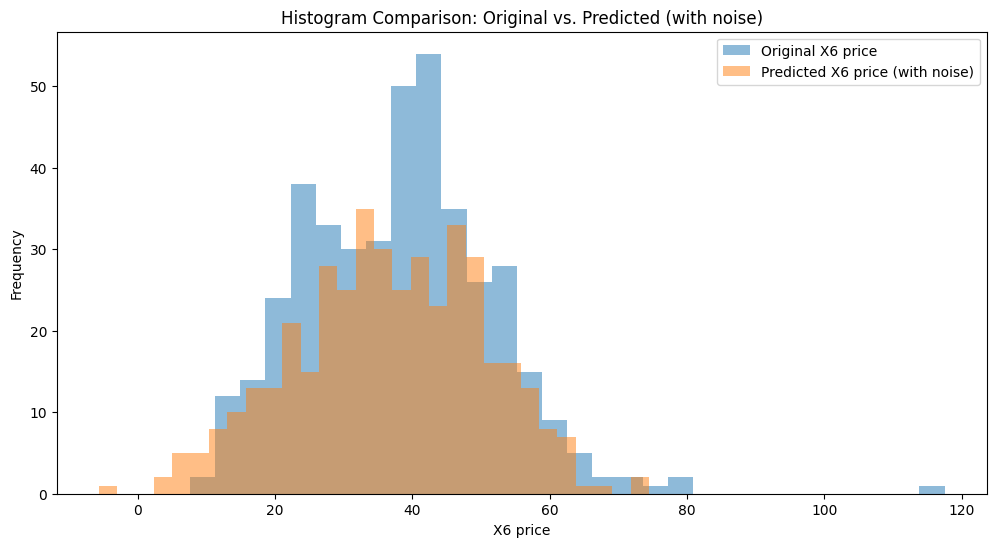

In [42]:
plt.figure(figsize=(12, 6))
plt.hist(y, bins=30, alpha=0.5, label="Original X6 price")
plt.hist(y_pred_with_noise, bins=30, alpha=0.5, label="Predicted X6 price (with noise)")
plt.xlabel("X6 price")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()